In [12]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [13]:
# 1.Fetch market data
# We will use 'BTC-USD' for this example as it provides a wide range of price action.

# %%
ticker = "BTC-USD"
# Fetching a significant amount of data to ensure we find patterns
data = yf.download(ticker, start="2023-01-01", end="2024-01-01")

# Fix for multi-index columns if they exist (common with recent yfinance versions)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data.dropna(inplace=True)
print(f"Data downloaded: {len(data)} rows.")
print(data.head())


/tmp/ipython-input-98982538.py:7: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

Data downloaded: 365 rows.
Price              Close          High           Low          Open  \
Date                                                                 
2023-01-01  16625.080078  16630.439453  16521.234375  16547.914062   
2023-01-02  16688.470703  16759.343750  16572.228516  16625.509766   
2023-01-03  16679.857422  16760.447266  16622.371094  16688.847656   
2023-01-04  16863.238281  16964.585938  16667.763672  16680.205078   
2023-01-05  16836.736328  16884.021484  16790.283203  16863.472656   

Price            Volume  
Date                     
2023-01-01   9244361700  
2023-01-02  12097775227  
2023-01-03  13903079207  
2023-01-04  18421743322  
2023-01-05  13692758566  


In [14]:
# 2.  Define specific metrics to identify the Hammer shape.
### Hammer Definition Used
"""
- Lower shadow >= 2* the real body (paper umbrella rule).
- Upper shadow very small (≤ 25% of body) to ensure body is near the top.
- Real body small (≤ 40% of full high–low range).
- A simple downtrend in prior 3 candles: each close lower than the previous.
- Colour of the real body is not enforced (bullish or bearish both allowed)."""
def identify_hammer(row):
    open_price = row['Open']
    close_price = row['Close']
    high = row['High']
    low = row['Low']

    # Calculate components
    real_body = abs(close_price - open_price)
    lower_shadow = min(open_price, close_price) - low
    upper_shadow = high - max(open_price, close_price)

    # Avoid division by zero for Doji-like candles (extremely small body)
    if real_body == 0:
        return False

    # 1. Lower shadow is at least 2x the real body (The "Hammer" handle)
    shadow_to_body_ratio = lower_shadow / real_body

    # 2. Upper shadow is tiny (less than 25% of the body size)
    # This ensures the price closed near the top of the range.
    upper_shadow_condition = upper_shadow <= (0.25 * real_body)

    # 3. Real body small (≤ 40% of full high–low range).
    real_body_condition = real_body <= (0.4 * (high - low))

    # Combine conditions
    if (shadow_to_body_ratio >= 2.0) and upper_shadow_condition and real_body_condition:
        return True
    else:
        return False

# Apply the logic to the DataFrame
data['is_hammer'] = data.apply(identify_hammer, axis=1)

In [15]:
# 3.  Calculate the frequency of the pattern.

# Count occurrences
hammer_days = data[data['is_hammer'] == True]
count = len(hammer_days)

print(f"Total Hammer patterns identified: {count}")
print("\nDates where Hammer was identified:")
print(hammer_days.index.date)


Total Hammer patterns identified: 6

Dates where Hammer was identified:
[datetime.date(2023, 1, 15) datetime.date(2023, 2, 22)
 datetime.date(2023, 3, 10) datetime.date(2023, 4, 6)
 datetime.date(2023, 8, 22) datetime.date(2023, 11, 3)]


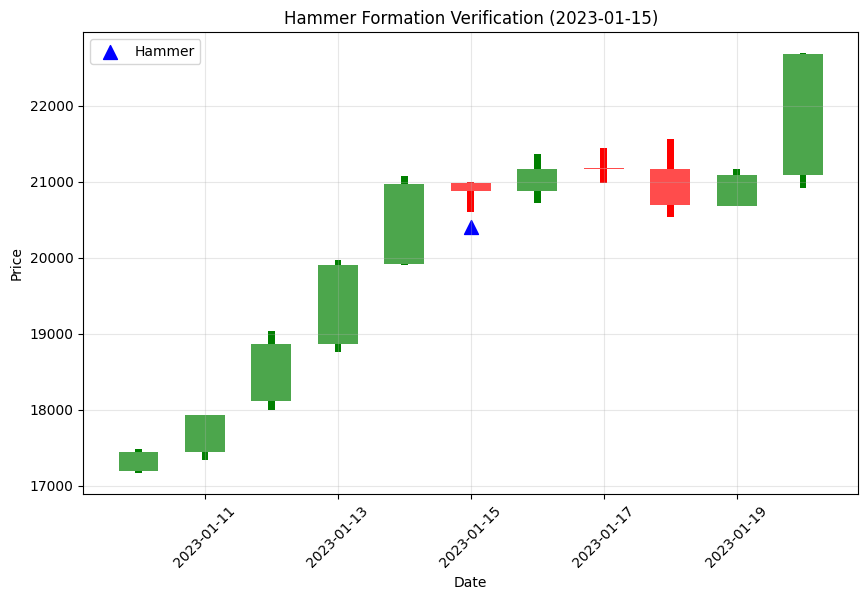

In [16]:
# 4.  Visualize a specific instance of a Hammer candle.

# We will plot one specific instance of a Hammer to visually verify the pattern. We will include a few days before and after to show the context.

if count > 0:
    # Select the first identified Hammer date
    target_date = hammer_days.index[0]

    # Define a window to plot (e.g., 5 days before and 5 days after)
    idx_loc = data.index.get_loc(target_date)
    start_idx = max(0, idx_loc - 5)
    end_idx = min(len(data), idx_loc + 6)

    subset = data.iloc[start_idx:end_idx]

    # --- Plotting with Plotly (Interactive) ---
    fig = go.Figure(data=[go.Candlestick(
        x=subset.index,
        open=subset['Open'],
        high=subset['High'],
        low=subset['Low'],
        close=subset['Close'],
        name='Price'
    )])

    # Add an annotation to point out the Hammer
    fig.add_annotation(
        x=target_date,
        y=data.loc[target_date]['Low'],
        xref="x",
        yref="y",
        text="Hammer Pattern",
        showarrow=True,
        arrowhead=1,
        yshift=-10
    )

    fig.update_layout(
        title=f'Hammer Pattern Identified on {target_date.date()}',
        yaxis_title='Price (USD)',
        xaxis_title='Date',
        template='plotly_dark'
    )

    fig.show()

    # --- Plotting with Matplotlib (Static) ---
    # Create figure
    plt.figure(figsize=(10, 6))

    # Define colors for candles
    up = subset[subset.Close >= subset.Open]
    down = subset[subset.Close < subset.Open]

    # Plot 'up' candles
    plt.bar(up.index, up.Close - up.Open, 0.6, bottom=up.Open, color='green', alpha=0.7)
    plt.bar(up.index, up.High - up.Close, 0.1, bottom=up.Close, color='green')
    plt.bar(up.index, up.Low - up.Open, 0.1, bottom=up.Open, color='green')

    # Plot 'down' candles
    plt.bar(down.index, down.Close - down.Open, 0.6, bottom=down.Open, color='red', alpha=0.7)
    plt.bar(down.index, down.High - down.Open, 0.1, bottom=down.Open, color='red')
    plt.bar(down.index, down.Low - down.Close, 0.1, bottom=down.Close, color='red')

    # Highlight the Hammer
    plt.scatter(target_date, data.loc[target_date]['Low'] * 0.99, color='blue', marker='^', s=100, label='Hammer')

    plt.title(f'Hammer Formation Verification ({target_date.date()})')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

else:
    print("No Hammer patterns found with the current strict metrics. Try adjusting the ratios.")